In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import sys
import matplotlib.pyplot as plt

sys.path.append("..")
from src import *

2024-08-06 08:32:19.936987: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-06 08:32:19.950008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 08:32:19.966217: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 08:32:19.971059: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 08:32:19.983004: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
blue = sns.color_palette("colorblind")[0]
pink = sns.color_palette("colorblind")[4] 

In [4]:
base = "/data/bionets" if "ramses" in os.uname()[1] else "/data_nfs/"

In [5]:
data = get_data_csv(high_quality_only=False, pfs=True, config_path=os.path.join(base, "je30bery/melanoma_data/config.json"))
data = data.reset_index().drop("index", axis=1)

data["Sex"].replace({"m": 1., "f": 0.}, inplace=True)
data["Ulcerated"].replace({True: 1., False: 0.}, inplace=True)

In [6]:
np.unique(data["PFS < 5"], return_counts=True)

(array([0., 1.]), array([97, 15]))

In [7]:
pfs0_pats = data[data["PFS < 5"] == 0]["Patient ID"]
pfs1_pats = data[data["PFS < 5"] == 0]["Patient ID"]
palette = {pat: blue for pat in pfs0_pats}.update({pat: pink for pat in pfs1_pats})

In [8]:
def plot_samples_distri(ax):
    pos = np.unique(data[data["PFS < 5"] == 1]["Patient ID"])
    neg = np.unique(data[data["PFS < 5"] == 0]["Patient ID"])
    palette = {pat: pink for i, pat in enumerate(pos)}
    palette.update({pat: blue for i, pat in enumerate(neg)})
    
    sns.histplot(data, x="PFS < 5", hue="Patient ID", multiple="stack", bins=2, legend=False, palette=palette, ax=ax)
    ax.set_xticks(ticks=[0.25,0.75], labels=["PFS ≥ 5", "PFS < 5"])
    #ax.set_title("Samples colored by patient ID")
    #plt.savefig("data_overview.png")
    return ax

___
Use leave-all-sample-of-one-patient-out approach on tabular features (baseline)

In [9]:
prediction, feature_imp = loo_forest(data=data, features=["Sex", "Age", "Tumor Thickness [mm]", "Ulcerated", "Coarse loc.", "Side"], label="PFS < 5")
data = data.sort_values("Histo ID", axis=0)
prediction = prediction.sort_values("Histo ID", axis=0)
#print("------- Sample level -------")
#print_metrics(data["PFS < 5"].values, prediction["Prediction"].values)
print("------- Histo ID level -------")
y_true, y_pred = get_histo_id_level_predictions(data, prediction)
print_metrics(np.array(y_true), np.array(y_pred))

------- Histo ID level -------
Accuracy 0.7142857142857143
F1 0.5
AUC-ROC 0.6500000000000001
Recall 0.5
Precision 0.5
Accuracy in negative class 0.8
Accuracy in positive class 0.5
Sensitivity (Recall): 0.5
Specificity: 0.8


In [10]:
def plot_thickness(ax):
    palette = {"PFS ≥ 5": blue, 
               "PFS < 5": pink}
    sns.histplot(data.replace({0: "PFS ≥ 5", 1: "PFS < 5"}), x="Tumor Thickness [mm]", hue="PFS < 5", palette=palette, multiple="layer", ax=ax)
    #plt.savefig("thickness_by_label.png")
    return ax

In [11]:
feature_imp.rename({"Tumor Thickness [mm]": "Tumor thickness"}, inplace=True, axis=1)

In [12]:
def plot_feature_imp(feature_imp, ax):
    sns.barplot(feature_imp, color="#ff8800", alpha=0.8, ax=ax, edgecolor="0.")
    #plt.title(f'Feature importance of Random Forest with\nleave-one-patient-out approach')
    ax.set_ylabel('Feature importance')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    #plt.savefig("fimp_with_thickness.png")
    return ax

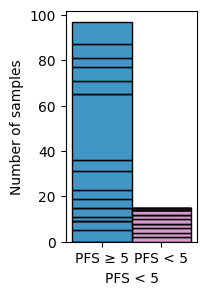

In [13]:
f, ax = plt.subplots(1, figsize=(1.7, 3))
ax = plot_samples_distri(ax)
ax.set_ylabel("Number of samples")
plt.savefig("../result_plots/sample_distri.svg", bbox_inches="tight")

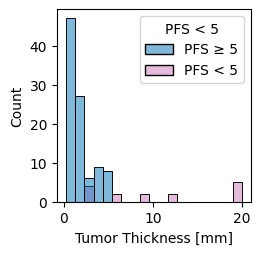

In [14]:
#f, axs = plt.subplots(1, 2, figsize=(7, 2.5))
#axs[0] = plot_samples_distri(axs[0])
#axs[0].text(-0.3, 103, "b", ha='center', va='bottom', weight="bold")

#axs[1] = plot_feature_imp(feature_imp, axs[1])
#axs[1].text(-0.25, 0.536, "b", ha='center', va='bottom', weight="bold")
f, ax = plt.subplots(1, figsize=(2.5, 2.5))

ax = plot_thickness(ax)
#ax.text(-5, 50, "c", ha='center', va='bottom', weight="bold")
#plt.tight_layout()
plt.savefig("../result_plots/tumor_thickness_distri.svg", bbox_inches="tight")

In [15]:
prediction, feature_imp = loo_forest(data=data, features=["Tumor Thickness [mm]"], label="PFS < 5")
data = data.sort_values("Histo ID", axis=0)
prediction = prediction.sort_values("Histo ID", axis=0)
#print("------- Sample level -------")
#print_metrics(data["PFS < 5"].values, prediction["Prediction"].values)
print("------- Histo ID level -------")
y_true, y_pred = get_histo_id_level_predictions(data, prediction)
print_metrics(np.array(y_true), np.array(y_pred))

------- Histo ID level -------
Accuracy 0.8214285714285714
F1 0.7368421052631579
AUC-ROC 0.8375
Recall 0.875
Precision 0.6363636363636364
Accuracy in negative class 0.8
Accuracy in positive class 0.875
Sensitivity (Recall): 0.875
Specificity: 0.8


In [16]:
prediction, feature_imp = loo_forest(data=data, features=["Sex", "Age", "Ulcerated", "Coarse loc.", "Side"], label="PFS < 5")
data = data.sort_values("Histo ID", axis=0)
prediction = prediction.sort_values("Histo ID", axis=0)
#print("------- Sample level -------")
#print_metrics(data["PFS < 5"].values, prediction["Prediction"].values)
print("------- Histo ID level -------")
y_true, y_pred = get_histo_id_level_predictions(data, prediction)
print_metrics(np.array(y_true), np.array(y_pred))

------- Histo ID level -------
Accuracy 0.6785714285714286
F1 0.3076923076923077
AUC-ROC 0.55
Recall 0.25
Precision 0.4
Accuracy in negative class 0.85
Accuracy in positive class 0.25
Sensitivity (Recall): 0.25
Specificity: 0.85


In [17]:
conc = pd.concat([data.set_index("Histo ID"), prediction.set_index("Histo ID")], axis=1)[["Patient ID", "PFS < 5", "Prediction"]].reset_index()